## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, GRU, Bidirectional, Embedding, Dense, TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-10-30 00:03:30.830637: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 00:03:30.833591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 00:03:30.843111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730243010.859038    8442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730243010.863817    8442 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 00:03:30.880426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:

BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [4]:
df.iloc[6,:]

comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
sum_injurious                                               4
Name: 6, dtype: object

In [5]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [6]:
len(df)

159571

 # IDEA!

 Posso fare il modello così:
1. Preprocessing del testo:
    - Gestione delle stop words, conversione in token e padding delle sequenze (Layer TextVectorization? da capire)
1. Embedding (classico, senza troppi fronzoli, Layer Embedding)
1. Parte ricorrente:
    - Uso le GRU (o LSTM, da decidere) con Bidirectional, così da vedere le sequenze in entrambi i versi
1. Fare ritornare al layer ricorrente tutta la sequenza:
    - Così in output ho shape `(batch_size, timestamps, n_features_RNN)`
1. Layer CNN:
    - tratto l'output della RNN come un'immagine a singolo canale, cioè `(batch_size,height,width)` = `(batch_size, timestamps, n_feat_RNN)`
    In sostanza, è come ottenere uno spettrogramma della sequenza, ma invece della trasformata di Fourier c'è l'output della RNN.
1. Layer di pooling (come fatto di solito nelle CNN).
1. Flattening (o qualche sostituto)
1. Layer denso con funz. di attivazione sigmoide:
    - Quesro layer è l'output. Ha `n_neuroni = n_classi`, dove ogni neurone farà una classificazione binaria per una classe possibile.
    Ogni neurone produce un elemento del vettore di output da 6 elementi di 0 e 1.

Non si usa la softmax in output poichè la softmax è usata quando c'è una relazione 1:1 tra record e classi (cioè 1 record ha solo 1 classe),
mentre qui la relazione è 1:N (1 record può avere più di una classe, cioè più 1 nell'output) 

In base a quanto scritto nella cella precedente, bisogna fare un passo di preprocessing anche per le classi.
Nel dataframe di partenza ho 1 colonna per ogni classe, mentre qui devo accorpare queste colonne in una singola colonna contenente una lista.


In [7]:
X = df["comment_text"].values
y = df.drop(["comment_text","sum_injurious"],axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(f"Train shapes, X:{X_train.shape}, y: {y_train.shape}") 
print(f"Test shapes, X:{X_test.shape}, y: {y_test.shape}")

Train shapes, X:(127656,), y: (127656, 6)
Test shapes, X:(31915,), y: (31915, 6)


<Axes: xlabel='sum_injurious', ylabel='Count'>

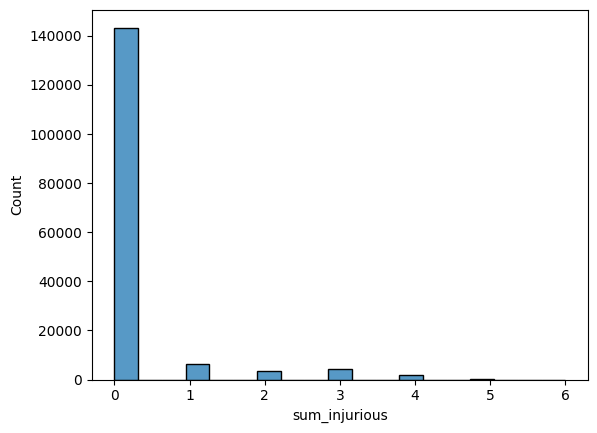

In [8]:
import seaborn as sns
sns.histplot(df, x="sum_injurious")

2024-10-30 00:03:37.775526: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


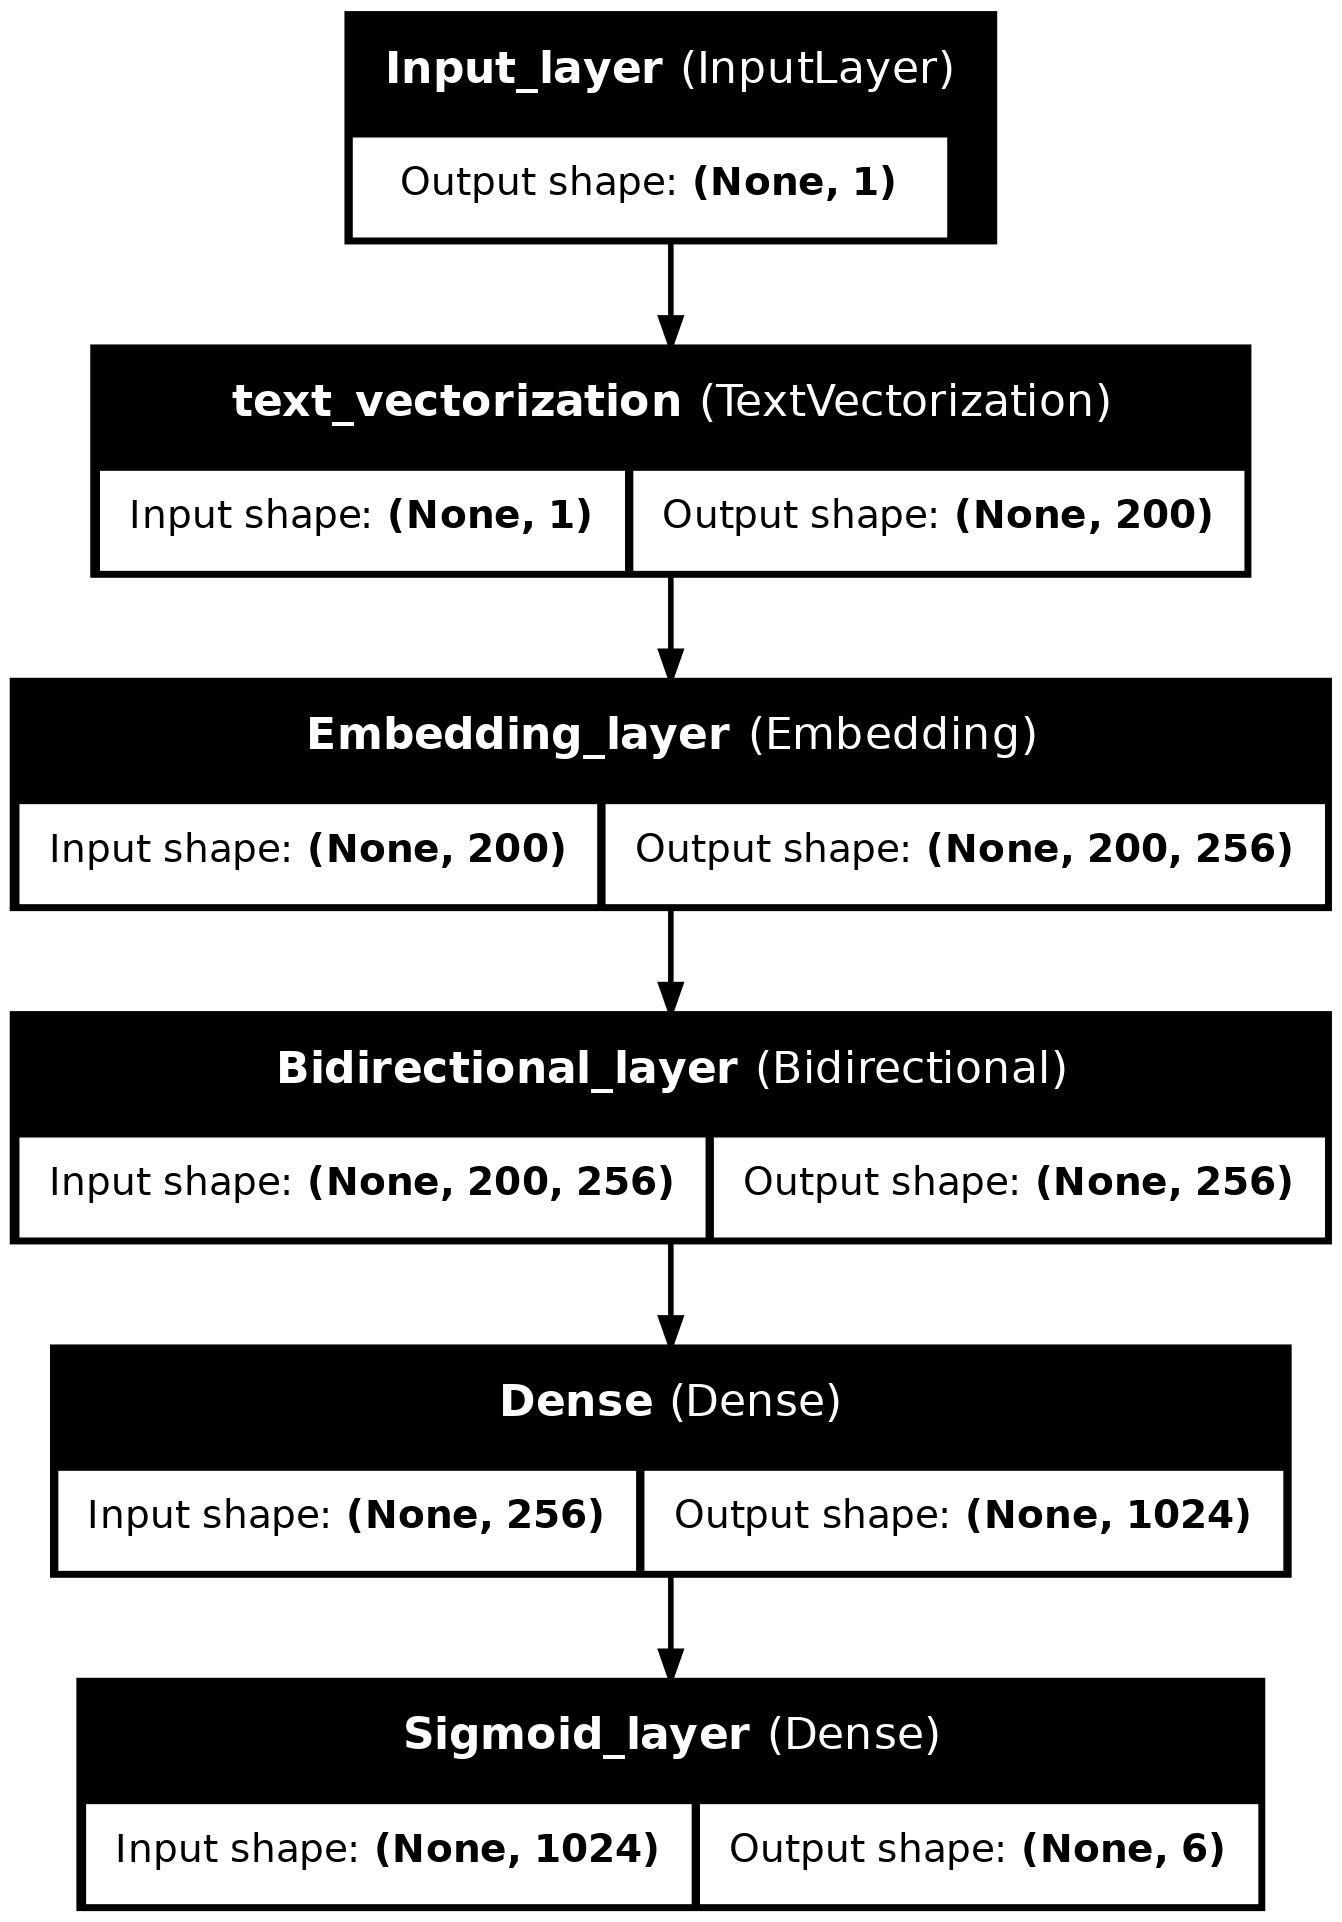

In [9]:
clear_session()

max_tokens = 10000 # Numero massimo di token nel vocabolario
max_len = 200 # Lunghezza massima delle sequenze di input
embedding_dim = 256 #dimensione embedding
rnn_dim = 128 #dimensione layer RNN

# input_layer = Input(shape = (maxlen_seq,), name="Input_layer")
input_layer = Input(shape = (1,),dtype='string', name="Input_layer")

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_test)
tmp = vectorize_layer(input_layer)

embedding_layer = Embedding(max_tokens, embedding_dim, name ="Embedding_layer")(tmp)
recursive_layer = Bidirectional(GRU(rnn_dim, return_sequences=False,name="GRU"),name="Bidirectional_layer")(embedding_layer)
dense_layer = Dense(1024, activation = 'relu', name ='Dense')(recursive_layer)
output_layer = Dense(6,activation='sigmoid', name = "Sigmoid_layer")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

plot_file = 'model_plot_new.png'
plot_model(model, to_file=plot_file, show_shapes=True, 
           show_layer_names=True)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','F1Score'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_layer (Embedding)     │ (None, 200, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional_layer             │ (None, 256)            │       296,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sigmoid_layer (Dense)           │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125,766 (11.92 MB)

 Trainable params: 3,125,766 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
history = model.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2)

Epoch 1/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 665s 207ms/step - F1Score: 0.0367 - accuracy: 0.9080 - loss: 0.0814 - val_F1Score: 0.0293 - val_accuracy: 0.9930 - val_loss: 0.0508
Epoch 2/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 657s 206ms/step - F1Score: 0.0343 - accuracy: 0.8935 - loss: 0.0458 - val_F1Score: 0.0353 - val_accuracy: 0.8766 - val_loss: 0.0484
Epoch 3/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 682s 206ms/step - F1Score: 0.0340 - accuracy: 0.8574 - loss: 0.0373 - val_F1Score: 0.0658 - val_accuracy: 0.5084 - val_loss: 0.0514
Epoch 4/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 657s 206ms/step - F1Score: 0.0557 - accuracy: 0.6564 - loss: 0.0301 - val_F1Score: 0.0425 - val_accuracy: 0.7998 - val_loss: 0.0571
Epoch 5/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 657s 206ms/step - F1Score: 0.0674 - accuracy: 0.6674 - loss: 0.0241 - val_F1Score: 0.0662 - val_accuracy: 0.6674 - val_loss: 0.0671
Epoch 6/20
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 657s 206ms/step - F1Score: 0.1121 - accuracy: 0.7172 - loss: 0.0180 - val_F1Score: 0.067

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(history.history["loss"], label= "train")
    plt.plot(history.history["val_loss"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss")
    plt.subplot(2,1,2)
    plt.plot(history.history["F1Score"], label="train")
    plt.plot(history.history["val_F1Score"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("F1Score")
    plt.show()

In [ ]:
plot_learning_curve(history)